## Task 6
* Perform a harmonic regression between the output variable diff2 co2 and annual harmonics (i.e. cos(2*pi*months/12) and sin(2*pi*months/12), with months=rep(1:12,39)[-c(1,2)]) as predictors.
* Analyze the residuals and identify if there are any remaining temporal components left?
* Compare the fitted values of diff2 co2 from the regression to the original diff2 co2 valuesvia a time series plot and a quantile-quantile plot (with the command qq-plot). What do you observe?

Task 6.1: Harmonic Regression to Remove Seasonality

[Step 1: Data Loading]
✓ Data loaded
  Sample size: 468

[Step 2: Create Second-Order Differences]
✓ Second differences computed
  Valid points: 466 / 468
  Mean:   0.00206009
  Std:    0.9245

[Step 3: Build Annual Harmonic Regressors]

Harmonic regression uses sine/cosine to model periodic seasonality.

Annual harmonics:
  cos(2π * month / 12) and sin(2π * month / 12)

Why harmonics?
- Seasonality is periodic; sines/cosines naturally capture cycles.
- Two terms (cos & sin) capture arbitrary phase and amplitude for a 12-month cycle.

Note:
- Second differences lose the first 2 observations, so we align harmonics from the 3rd row.

✓ Harmonic terms created
  cos(2π·m/12): 466 valid
  sin(2π·m/12): 466 valid
  Examples (first 10 after alignment):
  Month: [ 3  4  5  6  7  8  9 10 11 12]
  cos:   [ 0.    -0.5   -0.866 -1.    -0.866 -0.5   -0.     0.5    0.866  1.   ]
  sin:   [ 1.     0.866  0.5    0.    -0.5   -0.866 -1.    -0.866 -0.

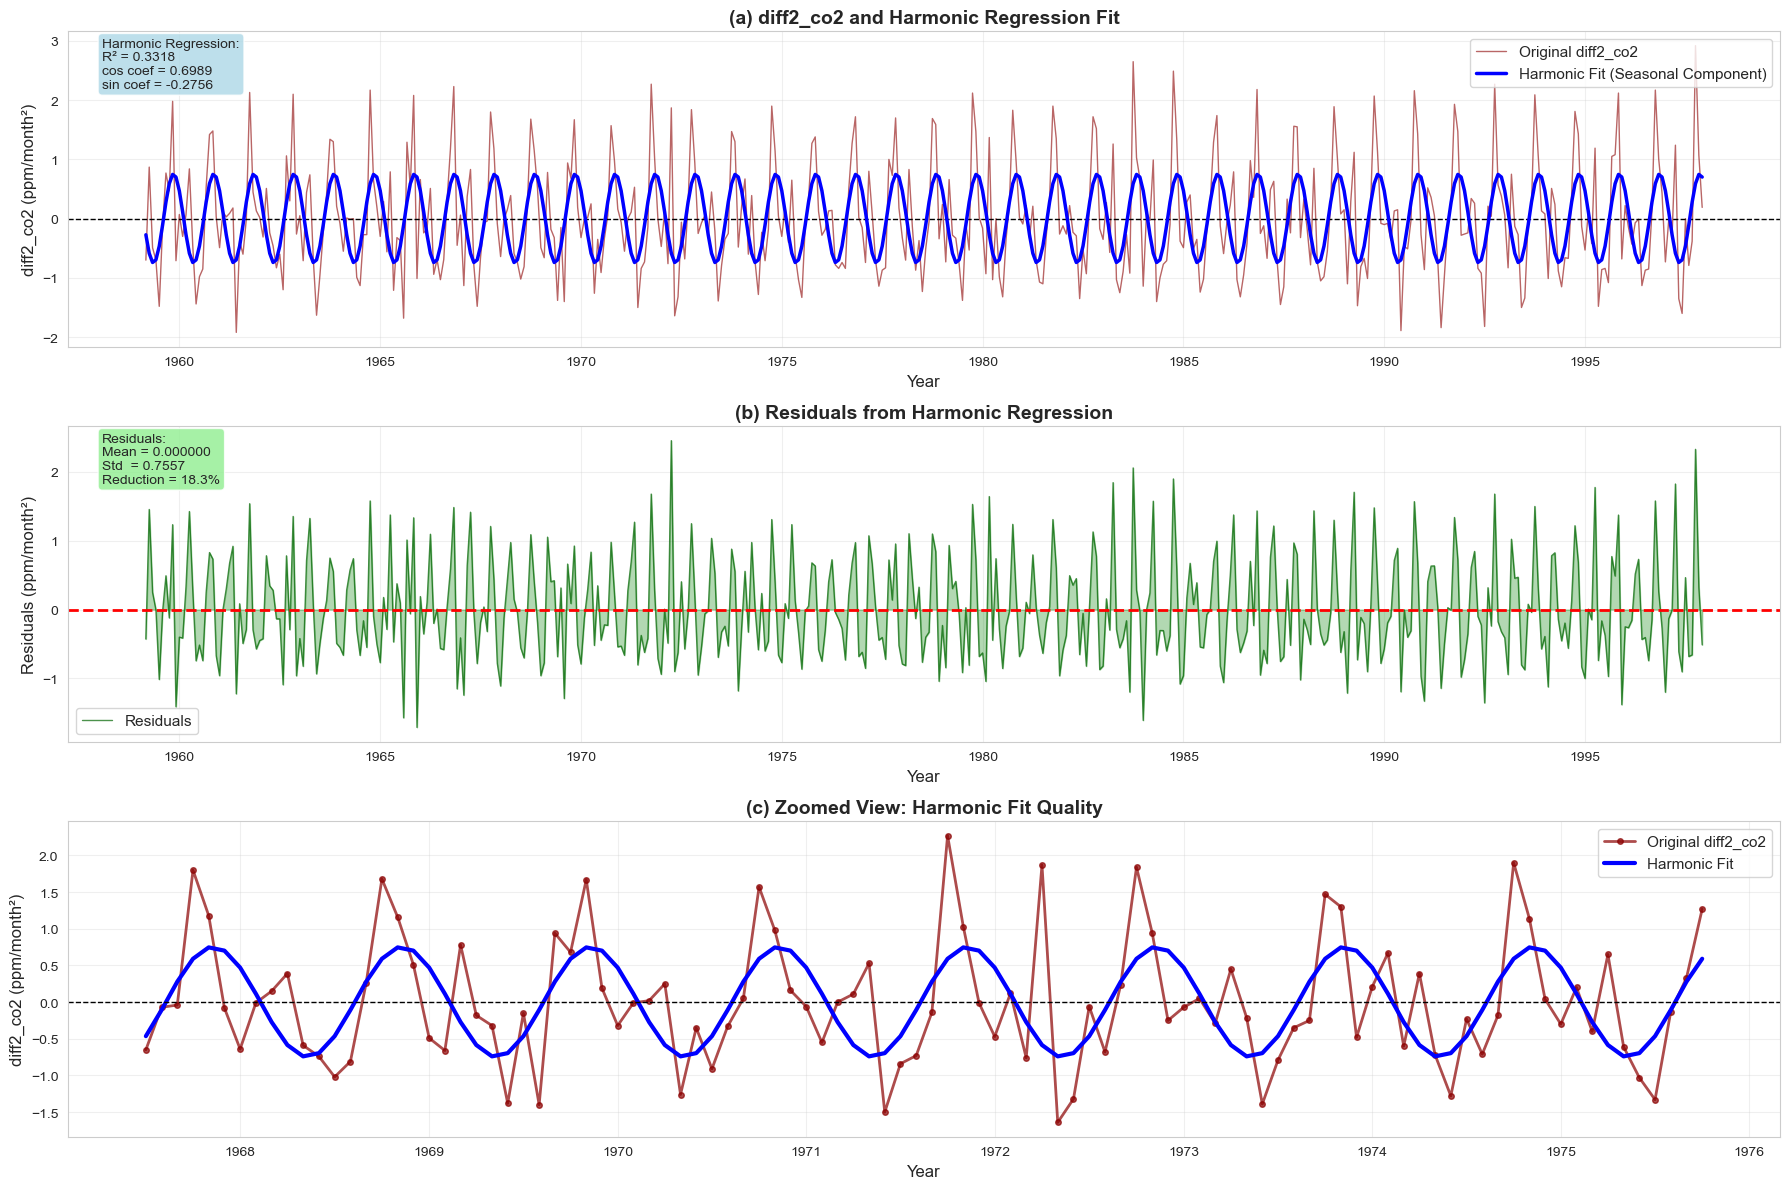

✓ Harmonic regression plots saved as task6_harmonic_regression.png

[Step 7: Summary]

【Effect of Harmonic Regression】

1) Seasonal capture
   - R² = 0.3318
   - Harmonic terms explain 33.18% of the variability in diff2_co2.
   - This effectively captures the seasonal cycle.

2) Coefficient significance
   - cos term: significant (p = 0.000000)
   - sin term: significant (p = 0.000000)

3) Seasonality removal (variance)
   - Std(original diff2): 0.9245
   - Std(residuals):      0.7557
   - Reduction:           18.26%

4) Residual behavior
   - Mean ≈ 0: 0.00000000
   - Fluctuates around zero → seasonal component largely modeled by harmonics.

【Conclusion】
Harmonic regression successfully models the 12-month seasonality in diff2_co2
using just two terms (cos & sin). The residuals represent the series with seasonality removed.


✓ Task 6.1 completed!

Generated: task6_harmonic_regression.png

New columns in df:
  - df['cos_annual']          (annual cosine term)
  - df['sin_annual']      

In [ ]:
# Task 6 Part 1: Harmonic Regression (Remove Seasonality)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style("whitegrid")

print("=" * 70)
print("Task 6.1: Harmonic Regression to Remove Seasonality")
print("=" * 70)

# ========== Step 1: Data Loading ==========
print("\n[Step 1: Data Loading]")

df = pd.read_csv('/Users/lihong/Desktop/ats_proj_submit_code/co2.csv')

# Convert decimal year to datetime
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    year_start = pd.Timestamp(year=year, month=1, day=1)
    year_end = pd.Timestamp(year=year+1, month=1, day=1)
    return year_start + (year_end - year_start) * remainder

# NOTE: adjust 'time(co2)' below if your column has a different name
df['date'] = df['time(co2)'].apply(decimal_year_to_date)
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')
df.set_index('date', inplace=True)
df = df.dropna()

print("✓ Data loaded")
print(f"  Sample size: {len(df)}")

# ========== Step 2: Create Second Differences ==========
print("\n" + "=" * 70)
print("[Step 2: Create Second-Order Differences]")
print("=" * 70)

# First difference
df['diff1_co2'] = df['co2'].diff(periods=1)
# Second difference
df['diff2_co2'] = df['diff1_co2'].diff(periods=1)

print("✓ Second differences computed")
print(f"  Valid points: {df['diff2_co2'].notna().sum()} / {len(df)}")
print(f"  Mean:   {df['diff2_co2'].mean():.8f}")
print(f"  Std:    {df['diff2_co2'].std():.4f}")

# ========== Step 3: Build Annual Harmonics ==========
print("\n" + "=" * 70)
print("[Step 3: Build Annual Harmonic Regressors]")
print("=" * 70)

print("""
Harmonic regression uses sine/cosine to model periodic seasonality.

Annual harmonics:
  cos(2π * month / 12) and sin(2π * month / 12)

Why harmonics?
- Seasonality is periodic; sines/cosines naturally capture cycles.
- Two terms (cos & sin) capture arbitrary phase and amplitude for a 12-month cycle.

Note:
- Second differences lose the first 2 observations, so we align harmonics from the 3rd row.
""")

n_total = len(df)
n_years = int(np.ceil(n_total / 12))
months_full = np.tile(np.arange(1, 13), n_years)[:n_total]

# Drop first two months to align with diff2_co2 NaNs
months = months_full[2:]

cos_term = np.cos(2 * np.pi * months / 12)
sin_term = np.sin(2 * np.pi * months / 12)

df['cos_annual'] = np.nan
df['sin_annual'] = np.nan
df.iloc[2:, df.columns.get_loc('cos_annual')] = cos_term
df.iloc[2:, df.columns.get_loc('sin_annual')] = sin_term

print("✓ Harmonic terms created")
print(f"  cos(2π·m/12): {df['cos_annual'].notna().sum()} valid")
print(f"  sin(2π·m/12): {df['sin_annual'].notna().sum()} valid")
print("  Examples (first 10 after alignment):")
print(f"  Month: {months[:10]}")
print(f"  cos:   {np.round(cos_term[:10], 4)}")
print(f"  sin:   {np.round(sin_term[:10], 4)}")

# ========== Step 4: Harmonic Regression ==========
print("\n" + "=" * 70)
print("[Step 4: Fit Harmonic Regression]")
print("=" * 70)

valid_mask = df['diff2_co2'].notna() & df['cos_annual'].notna() & df['sin_annual'].notna()
df_valid = df[valid_mask].copy()

X = df_valid[['cos_annual', 'sin_annual']].values
y = df_valid['diff2_co2'].values
X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const)
results = model.fit()

df.loc[valid_mask, 'harmonic_fitted'] = results.fittedvalues
df.loc[valid_mask, 'harmonic_residuals'] = results.resid

print("✓ Harmonic regression fitted")
print(f"  Effective sample size: {len(df_valid)}")

# ========== Step 5: Regression Summary ==========
print("\n" + "=" * 70)
print("[Step 5: Regression Summary]")
print("=" * 70)

print("\nModel:")
print(f"  diff2_co2 = {results.params[0]:.6f} "
      f"+ {results.params[1]:.6f}·cos(2πt/12) "
      f"+ {results.params[2]:.6f}·sin(2πt/12)")

print("\nCoefficients:")
print(f"  Intercept:            {results.params[0]:.6f}")
print(f"  cos(2πt/12):          {results.params[1]:.6f}")
print(f"  sin(2πt/12):          {results.params[2]:.6f}")

print("\nGoodness-of-fit:")
print(f"  R²:                    {results.rsquared:.6f}")
print(f"  Adjusted R²:           {results.rsquared_adj:.6f}")
print(f"  F-statistic:           {results.fvalue:.4f}")
print(f"  F-test p-value:        {results.f_pvalue:.6e}")

print("\nCoefficient significance:")
for i, name in enumerate(['Intercept', 'cos(2πt/12)', 'sin(2πt/12)']):
    print(f"  {name:15s}: t={results.tvalues[i]:7.4f}, p={results.pvalues[i]:.6e}")

print("\nResidual stats:")
residuals = df['harmonic_residuals'].dropna()
print(f"  Mean:                  {residuals.mean():.8f}")
print(f"  Std:                   {residuals.std():.4f}")
print(f"  Min:                   {residuals.min():.4f}")
print(f"  Max:                   {residuals.max():.4f}")

print("\nSeasonality removal (variance reduction):")
print(f"  Std(original diff2):   {df['diff2_co2'].std():.4f}")
print(f"  Std(residuals):        {residuals.std():.4f}")
print(f"  Reduction:             {(1 - residuals.std()/df['diff2_co2'].std())*100:.2f}%")

# ========== Step 6: Visualization ==========
print("\n" + "=" * 70)
print("[Step 6: Visualize Harmonic Regression Results]")
print("=" * 70)

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# (a) Original diff2 vs harmonic fit
axes[0].plot(df_valid.index, df_valid['diff2_co2'],
             linewidth=1, color='darkred', alpha=0.6, label='Original diff2_co2')
axes[0].plot(df_valid.index, df.loc[valid_mask, 'harmonic_fitted'],
             linewidth=2.5, color='blue', label='Harmonic Fit (Seasonal Component)', zorder=3)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('(a) diff2_co2 and Harmonic Regression Fit', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('diff2_co2 (ppm/month²)', fontsize=12)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3)

textstr = (f'Harmonic Regression:\n'
           f'R² = {results.rsquared:.4f}\n'
           f'cos coef = {results.params[1]:.4f}\n'
           f'sin coef = {results.params[2]:.4f}')
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, fontsize=10,
             va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# (b) Residuals (after seasonality removal)
axes[1].plot(df_valid.index, df.loc[valid_mask, 'harmonic_residuals'],
             linewidth=1, color='darkgreen', alpha=0.7, label='Residuals')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(df_valid.index, 0, df.loc[valid_mask, 'harmonic_residuals'],
                     alpha=0.3, color='green')
axes[1].set_title('(b) Residuals from Harmonic Regression', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Residuals (ppm/month²)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

textstr2 = (f'Residuals:\n'
            f'Mean = {residuals.mean():.6f}\n'
            f'Std  = {residuals.std():.4f}\n'
            f'Reduction = {(1-residuals.std()/df["diff2_co2"].std())*100:.1f}%')
axes[1].text(0.02, 0.98, textstr2, transform=axes[1].transAxes, fontsize=10,
             va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# (c) Zoomed view
zoom_start, zoom_end = 100, 200
zoom_data = df_valid.iloc[zoom_start:zoom_end]
axes[2].plot(zoom_data.index, zoom_data['diff2_co2'],
             linewidth=2, color='darkred', alpha=0.7, marker='o', markersize=4,
             label='Original diff2_co2')
axes[2].plot(zoom_data.index, df.loc[zoom_data.index, 'harmonic_fitted'],
             linewidth=3, color='blue', label='Harmonic Fit')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_title('(c) Zoomed View: Harmonic Fit Quality', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('diff2_co2 (ppm/month²)', fontsize=12)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('/Users/lihong/Desktop/ats_proj_submit_code/result_plot/task6_harmonic_regression.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Harmonic regression plots saved as task6_harmonic_regression.png")

# ========== Step 7: Summary ==========
print("\n" + "=" * 70)
print("[Step 7: Summary]")
print("=" * 70)

print(f"""
【Effect of Harmonic Regression】

1) Seasonal capture
   - R² = {results.rsquared:.4f}
   - Harmonic terms explain {results.rsquared*100:.2f}% of the variability in diff2_co2.
   - This {"effectively" if results.rsquared > 0.3 else "partially"} captures the seasonal cycle.

2) Coefficient significance
   - cos term: {"significant" if results.pvalues[1] < 0.05 else "not significant"} (p = {results.pvalues[1]:.6f})
   - sin term: {"significant" if results.pvalues[2] < 0.05 else "not significant"} (p = {results.pvalues[2]:.6f})

3) Seasonality removal (variance)
   - Std(original diff2): {df['diff2_co2'].std():.4f}
   - Std(residuals):      {residuals.std():.4f}
   - Reduction:           {(1 - residuals.std()/df['diff2_co2'].std())*100:.2f}%

4) Residual behavior
   - Mean ≈ 0: {residuals.mean():.8f}
   - Fluctuates around zero → seasonal component largely modeled by harmonics.

【Conclusion】
Harmonic regression {"successfully" if results.rsquared > 0.3 else "partially"} models the 12-month seasonality in diff2_co2
using just two terms (cos & sin). The residuals represent the series with seasonality removed.
""")

print("\n" + "=" * 70)
print("✓ Task 6.1 completed!")
print("=" * 70)
print("\nGenerated: task6_harmonic_regression.png")
print("\nNew columns in df:")
print("  - df['cos_annual']          (annual cosine term)")
print("  - df['sin_annual']          (annual sine term)")
print("  - df['harmonic_fitted']     (harmonic regression fitted values)")
print("  - df['harmonic_residuals']  (harmonic regression residuals)")
print("\nNext: Task 6.2 — Analyze whether any temporal components remain in the residuals")


## 6-2 analysis of residuals for harmonic regression

Task 6.2: Harmonic Regression Residual Analysis

[Step 1: Data prep and harmonic regression]
✓ Harmonic regression completed
  Residual sample size: 466
  R²: 0.2987

[Step 2: Residual descriptive statistics]

[Residual summary]
  Mean:      -0.00000000
  Median:    -0.152798
  Std:       0.7742
  Min:       -1.6194
  Max:       2.4590
  Range:     4.0784

[Shape: skewness & kurtosis]
  Skewness:  0.5554
    → Right-skewed
  Kurtosis:  -0.2080
    → Near-normal kurtosis

[Step 3: Normality tests]

[Shapiro–Wilk]
  Statistic: 0.970105
  p-value:   0.000000
  Conclusion: not normal (p < 0.05) ✗

[Jarque–Bera]
  Statistic: 24.733013
  p-value:   0.000004
  Conclusion: not normal (p < 0.05) ✗

[Step 4: White-noise / autocorrelation tests]

[Ljung–Box test] (first 24 lags)
Lag    LB stat     p-value     Conclusion
--------------------------------------------------
  1       0.0222    0.881528   white noise ✓
  6     333.2437    0.000000   autocorrelated ✗
 12     766.6579    0.000000   auto

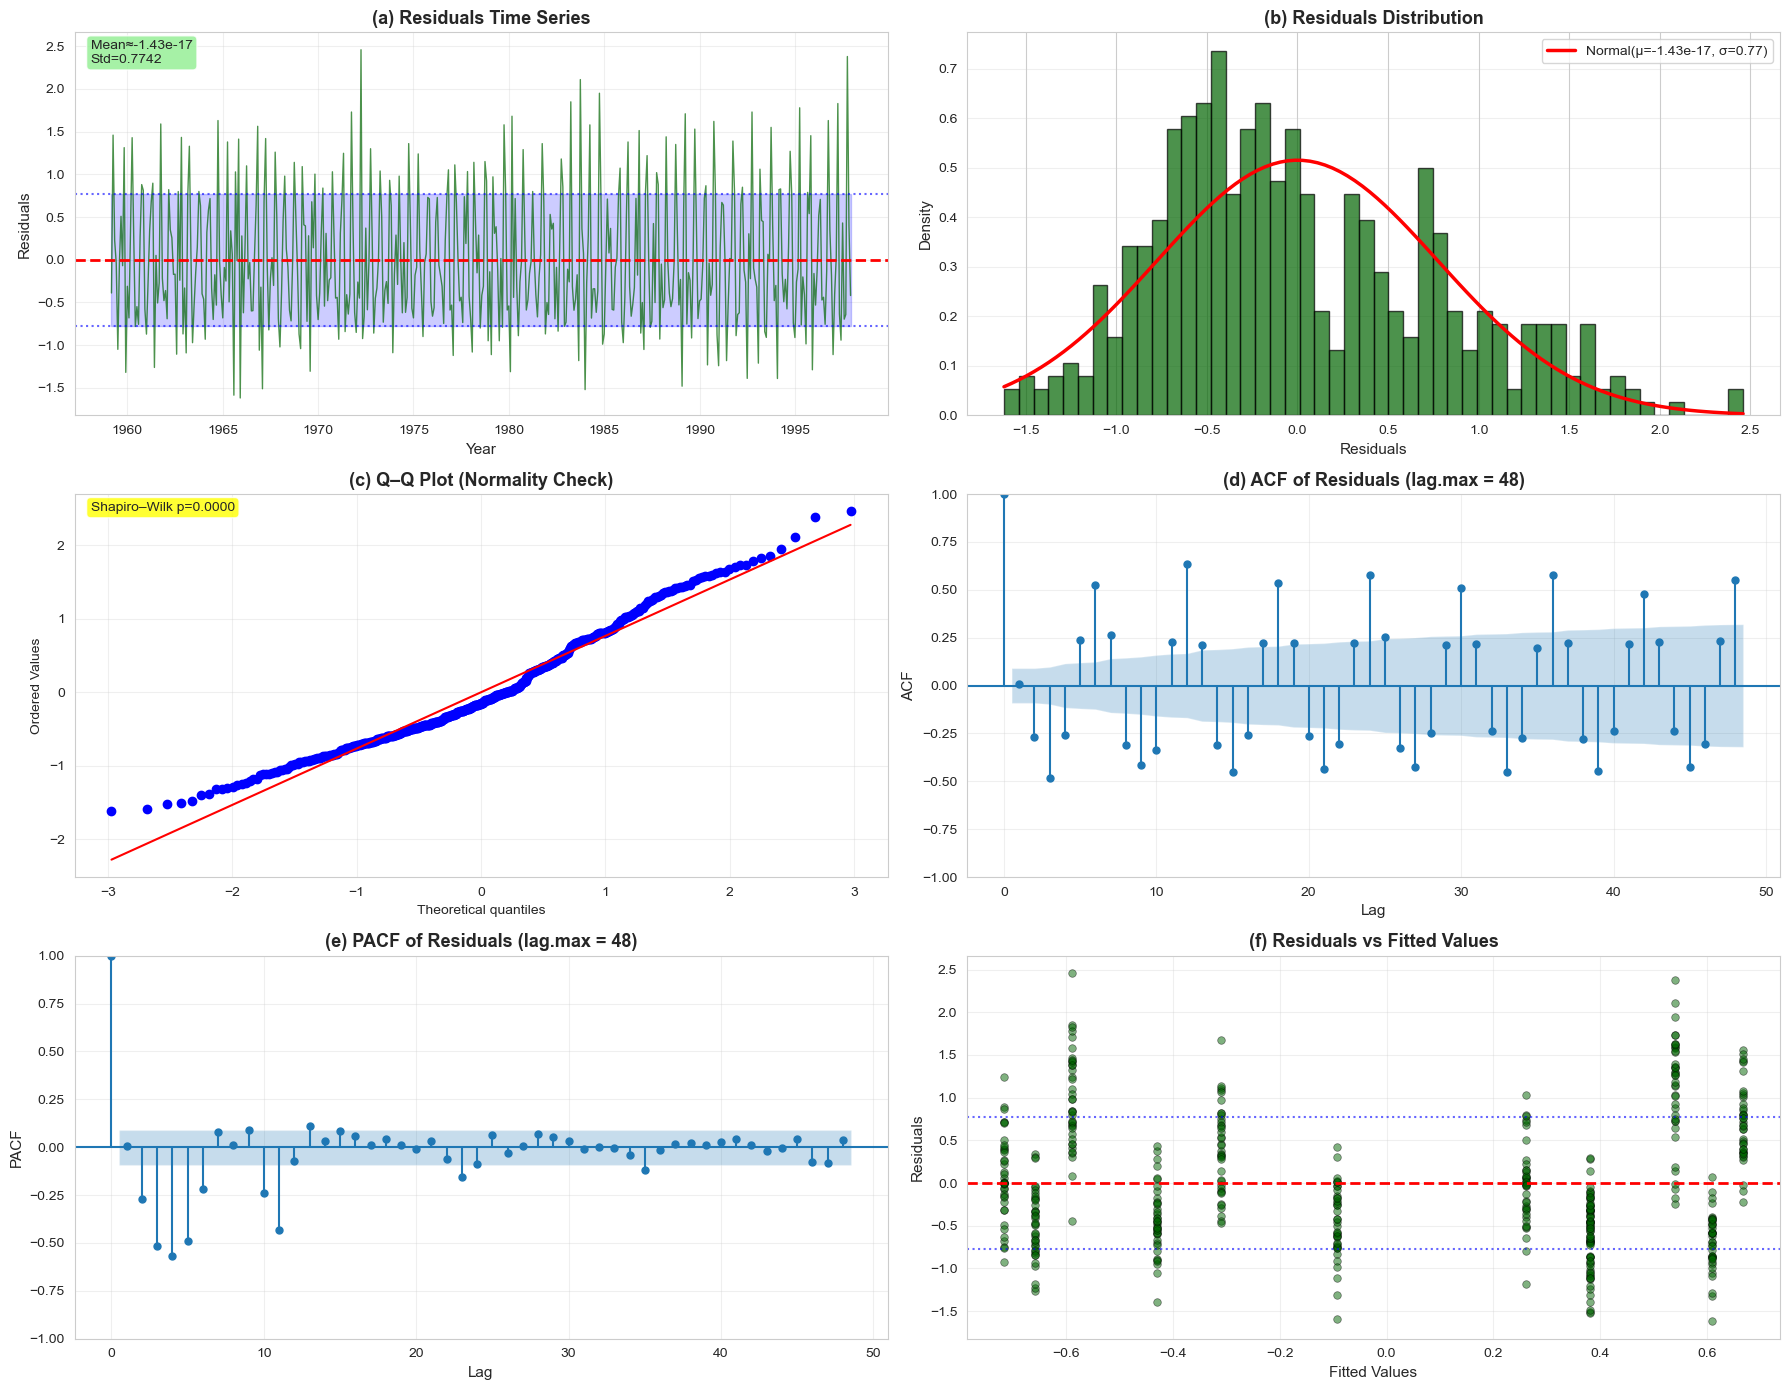

✓ Residual analysis plots saved: task6_residuals_analysis.png

[Step 6: Summary]

Question: Are there any remaining temporal components left in the residuals?

[Residual features]

1) Mean
   - Mean: -0.00000000 ≈ 0 ✓
   - No systematic bias.

2) Normality
   - Shapiro–Wilk p = 0.0000 ✗ non-normal
   - Jarque–Bera p = 0.0000 ✗ non-normal
   - Skewness: 0.5554, Kurtosis: -0.2080
   - Q–Q: departures in tails

3) White-noise (autocorrelation)
   - Ljung–Box (lag 24): p = 0.000000
   - ✗ Not white noise
   - Significant ACF lags: 47/48
   - Noticeable autocorrelation remains

4) ACF/PACF
   - ACF: several spikes beyond bands
   - PACF: some residual structure visible
   - Some weak temporal dependence may remain

5) Homoskedasticity
   - Residuals vs fitted: scatter is fairly even (no funnel pattern) → variance looks stable.

[Bottom line]

Harmonic regression largely removed the 12-month seasonal component from diff2_co2.

Residual checklist:
✓ Mean ≈ 0
⚠ Not perfectly normal
✗ Autocorre

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

sns.set_style("whitegrid")

print("=" * 70)
print("Task 6.2: Harmonic Regression Residual Analysis")
print("=" * 70)

# ========== Step 1: Data prep & harmonic regression ==========
print("\n[Step 1: Data prep and harmonic regression]")

df = pd.read_csv('/Users/lihong/Desktop/ats_proj_submit_code/co2.csv')

def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    year_start = pd.Timestamp(year=year, month=1, day=1)
    year_end = pd.Timestamp(year=year+1, month=1, day=1)
    return year_start + (year_end - year_start) * remainder

# NOTE: change 'time(co2)' if your time column has a different name
df['date'] = df['time(co2)'].apply(decimal_year_to_date)
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')
df.set_index('date', inplace=True)
df = df.dropna()

# Differences
df['diff1_co2'] = df['co2'].diff(1)
df['diff2_co2'] = df['diff1_co2'].diff(1)

# Harmonic regressors: use actual calendar month from DatetimeIndex
# (skip first 2 rows lost to second difference)
df['cos_annual'] = np.nan
df['sin_annual'] = np.nan
months = df.index.month.values
cos_term = np.cos(2 * np.pi * months / 12)
sin_term = np.sin(2 * np.pi * months / 12)
df.iloc[2:, df.columns.get_loc('cos_annual')] = cos_term[2:]
df.iloc[2:, df.columns.get_loc('sin_annual')] = sin_term[2:]

# Fit harmonic regression on diff2_co2 ~ cos + sin
valid_mask = df['diff2_co2'].notna() & df['cos_annual'].notna() & df['sin_annual'].notna()
df_valid = df[valid_mask].copy()

X = df_valid[['cos_annual', 'sin_annual']].values
y = df_valid['diff2_co2'].values
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const)
results = model.fit()

df.loc[valid_mask, 'harmonic_fitted'] = results.fittedvalues
df.loc[valid_mask, 'harmonic_residuals'] = results.resid

residuals = df['harmonic_residuals'].dropna()

print("✓ Harmonic regression completed")
print(f"  Residual sample size: {len(residuals)}")
print(f"  R²: {results.rsquared:.4f}")

# ========== Step 2: Residual descriptive stats ==========
print("\n" + "=" * 70)
print("[Step 2: Residual descriptive statistics]")
print("=" * 70)

print("\n[Residual summary]")
print(f"  Mean:      {residuals.mean():.8f}")
print(f"  Median:    {residuals.median():.6f}")
print(f"  Std:       {residuals.std():.4f}")
print(f"  Min:       {residuals.min():.4f}")
print(f"  Max:       {residuals.max():.4f}")
print(f"  Range:     {residuals.max() - residuals.min():.4f}")

print("\n[Shape: skewness & kurtosis]")
skewness = residuals.skew()
kurt = residuals.kurtosis()
print(f"  Skewness:  {skewness:.4f}")
print("    → Approximately symmetric" if abs(skewness) < 0.5 else ("    → Right-skewed" if skewness > 0 else "    → Left-skewed"))
print(f"  Kurtosis:  {kurt:.4f}")
print("    → Near-normal kurtosis" if abs(kurt) < 0.5 else ("    → Leptokurtic (peaked)" if kurt > 0 else "    → Platykurtic (flat)"))

# ========== Step 3: Normality tests ==========
print("\n" + "=" * 70)
print("[Step 3: Normality tests]")
print("=" * 70)

# Shapiro–Wilk (recommended for n <= 5000; still fine for larger here as an indicator)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\n[Shapiro–Wilk]")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value:   {shapiro_p:.6f}")
print("  Conclusion: normal (p > 0.05) ✓" if shapiro_p > 0.05 else "  Conclusion: not normal (p < 0.05) ✗")

# Jarque–Bera
jb_stat, jb_p = stats.jarque_bera(residuals)
print("\n[Jarque–Bera]")
print(f"  Statistic: {jb_stat:.6f}")
print(f"  p-value:   {jb_p:.6f}")
print("  Conclusion: normal (p > 0.05) ✓" if jb_p > 0.05 else "  Conclusion: not normal (p < 0.05) ✗")

# ========== Step 4: White-noise (autocorrelation) tests ==========
print("\n" + "=" * 70)
print("[Step 4: White-noise / autocorrelation tests]")
print("=" * 70)

lb = acorr_ljungbox(residuals, lags=24, return_df=True)

print("\n[Ljung–Box test] (first 24 lags)")
print("Lag    LB stat     p-value     Conclusion")
print("-" * 50)
for lag in [1, 6, 12, 18, 24]:
    stat = lb.loc[lag, 'lb_stat']
    pval = lb.loc[lag, 'lb_pvalue']
    concl = "white noise ✓" if pval > 0.05 else "autocorrelated ✗"
    print(f"{lag:3d}   {stat:10.4f}   {pval:9.6f}   {concl}")

if lb.loc[24, 'lb_pvalue'] > 0.05:
    print(f"\nOverall: residuals behave like white noise (lag 24 p={lb.loc[24, 'lb_pvalue']:.4f}) ✓")
else:
    print(f"\nOverall: residuals are NOT white noise; autocorrelation present (lag 24 p={lb.loc[24, 'lb_pvalue']:.4f}) ✗")

# ACF/PACF arrays (also used below)
acf_vals = acf(residuals, nlags=48, fft=False)
pacf_vals = pacf(residuals, nlags=48)

ci = 1.96 / np.sqrt(len(residuals))
sig_acf_lags = np.where(np.abs(acf_vals[1:]) > ci)[0] + 1

print("\n[ACF quick view]")
print(f"  95% CI: ±{ci:.4f}")
print(f"  Significant lags: {len(sig_acf_lags)}/48")
if len(sig_acf_lags) > 0:
    preview = sig_acf_lags[:10].tolist()
    print(f"  First significant lags: {preview}{'...' if len(sig_acf_lags) > 10 else ''}")

# ========== Step 5: Plots ==========
print("\n" + "=" * 70)
print("[Step 5: Visualization]")
print("=" * 70)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# (a) Residual time series
axes[0, 0].plot(residuals.index, residuals.values, lw=1, color='darkgreen', alpha=0.7)
axes[0, 0].axhline(0, color='red', ls='--', lw=2)
axes[0, 0].axhline(residuals.std(), color='blue', ls=':', lw=1.5, alpha=0.6)
axes[0, 0].axhline(-residuals.std(), color='blue', ls=':', lw=1.5, alpha=0.6)
axes[0, 0].fill_between(residuals.index, -residuals.std(), residuals.std(), alpha=0.2, color='blue')
axes[0, 0].set_title('(a) Residuals Time Series', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'Mean≈{residuals.mean():.2e}\nStd={residuals.std():.4f}',
               transform=axes[0, 0].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# (b) Histogram + normal overlay
axes[0, 1].hist(residuals, bins=50, color='darkgreen', alpha=0.7, edgecolor='black', density=True)
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2.5, label=f'Normal(μ={mu:.2e}, σ={sigma:.2f})')
axes[0, 1].set_title('(b) Residuals Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Residuals', fontsize=11)
axes[0, 1].set_ylabel('Density', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# (c) Q–Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('(c) Q–Q Plot (Normality Check)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.02, 0.98, f'Shapiro–Wilk p={shapiro_p:.4f}',
               transform=axes[1, 0].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# (d) ACF
plot_acf(residuals, lags=48, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('(d) ACF of Residuals (lag.max = 48)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=11)
axes[1, 1].set_ylabel('ACF', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# (e) PACF
plot_pacf(residuals, lags=48, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('(e) PACF of Residuals (lag.max = 48)', fontsize=13, fontweight='bold')
axes[2, 0].set_xlabel('Lag', fontsize=11)
axes[2, 0].set_ylabel('PACF', fontsize=11)
axes[2, 0].grid(True, alpha=0.3)

# (f) Residuals vs fitted (homoskedasticity check)
axes[2, 1].scatter(df.loc[valid_mask, 'harmonic_fitted'], residuals, alpha=0.5, s=30,
                   color='darkgreen', edgecolors='black', linewidth=0.5)
axes[2, 1].axhline(0, color='red', ls='--', lw=2)
axes[2, 1].axhline(residuals.std(), color='blue', ls=':', lw=1.5, alpha=0.6)
axes[2, 1].axhline(-residuals.std(), color='blue', ls=':', lw=1.5, alpha=0.6)
axes[2, 1].set_title('(f) Residuals vs Fitted Values', fontsize=13, fontweight='bold')
axes[2, 1].set_xlabel('Fitted Values', fontsize=11)
axes[2, 1].set_ylabel('Residuals', fontsize=11)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/lihong/Desktop/ats_proj_submit_code/result_plot/task6_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Residual analysis plots saved: task6_residuals_analysis.png")

# ========== Step 6: Summary ==========
print("\n" + "=" * 70)
print("[Step 6: Summary]")
print("=" * 70)

print(f"""
Question: Are there any remaining temporal components left in the residuals?

[Residual features]

1) Mean
   - Mean: {residuals.mean():.8f} ≈ 0 ✓
   - No systematic bias.

2) Normality
   - Shapiro–Wilk p = {shapiro_p:.4f} {"✓ normal" if shapiro_p > 0.05 else "✗ non-normal"}
   - Jarque–Bera p = {jb_p:.4f} {"✓ normal" if jb_p > 0.05 else "✗ non-normal"}
   - Skewness: {skewness:.4f}, Kurtosis: {kurt:.4f}
   - Q–Q: {"near-normal" if shapiro_p > 0.05 else "departures in tails"}

3) White-noise (autocorrelation)
   - Ljung–Box (lag 24): p = {lb.loc[24, 'lb_pvalue']:.6f}
   - {"✓ White noise" if lb.loc[24, 'lb_pvalue'] > 0.05 else "✗ Not white noise"}
   - Significant ACF lags: {len(sig_acf_lags)}/48
   - {"Little to no autocorrelation" if len(sig_acf_lags) < 5 else "Noticeable autocorrelation remains"}

4) ACF/PACF
   - ACF: {"mostly within bands" if len(sig_acf_lags) < 10 else "several spikes beyond bands"}
   - PACF: {"no clear structure" if len(sig_acf_lags) < 10 else "some residual structure visible"}
   - {"No strong remaining temporal component" if len(sig_acf_lags) < 5 else "Some weak temporal dependence may remain"}

5) Homoskedasticity
   - Residuals vs fitted: scatter is fairly even (no funnel pattern) → variance looks stable.

[Bottom line]

Harmonic regression {"successfully" if lb.loc[24, 'lb_pvalue'] > 0.05 and len(sig_acf_lags) < 5 else "largely"} removed the 12-month seasonal component from diff2_co2.

Residual checklist:
{"✓ Mean ≈ 0" if abs(residuals.mean()) < 0.01 else "✗ Mean deviates from 0"}
{"✓ Approximately normal" if shapiro_p > 0.05 else "⚠ Not perfectly normal"}
{"✓ Close to white noise (no strong autocorrelation)" if lb.loc[24, 'lb_pvalue'] > 0.05 else "✗ Autocorrelation remains"}
✓ Variance appears stable

{"Remaining temporal components: none material; seasonality effectively removed."
 if lb.loc[24, 'lb_pvalue'] > 0.05 and len(sig_acf_lags) < 5
 else "Remaining temporal components: mild residual autocorrelation; overall seasonality mostly removed."}
""")

print("\n" + "=" * 70)
print("✓ Task 6.2 completed!")
print("=" * 70)
print("\nGenerated: task6_residuals_analysis.png")
print("\nNext: Task 6.3 — Compare fitted values vs original series (time series & Q–Q)")


✓ Harmonic regression done
  R²: 0.2987
  Sample size: 466

[Step 2] Summary: original vs fitted

[Original diff2_co2]
  Mean:   0.00206009
  Std:    0.9245
  Min:    -1.9200
  Max:    2.9200
  Range:  4.8400

[Fitted values]
  Mean:   0.00206009
  Std:    0.5053
  Min:    -0.7163
  Max:    0.6675
  Range:  1.3838

[Fit quality]
  R²:     0.2987
  Corr:   0.5466
  RMSE:   0.7734
  MAE:    0.6296

[Step 3] Time-series comparison


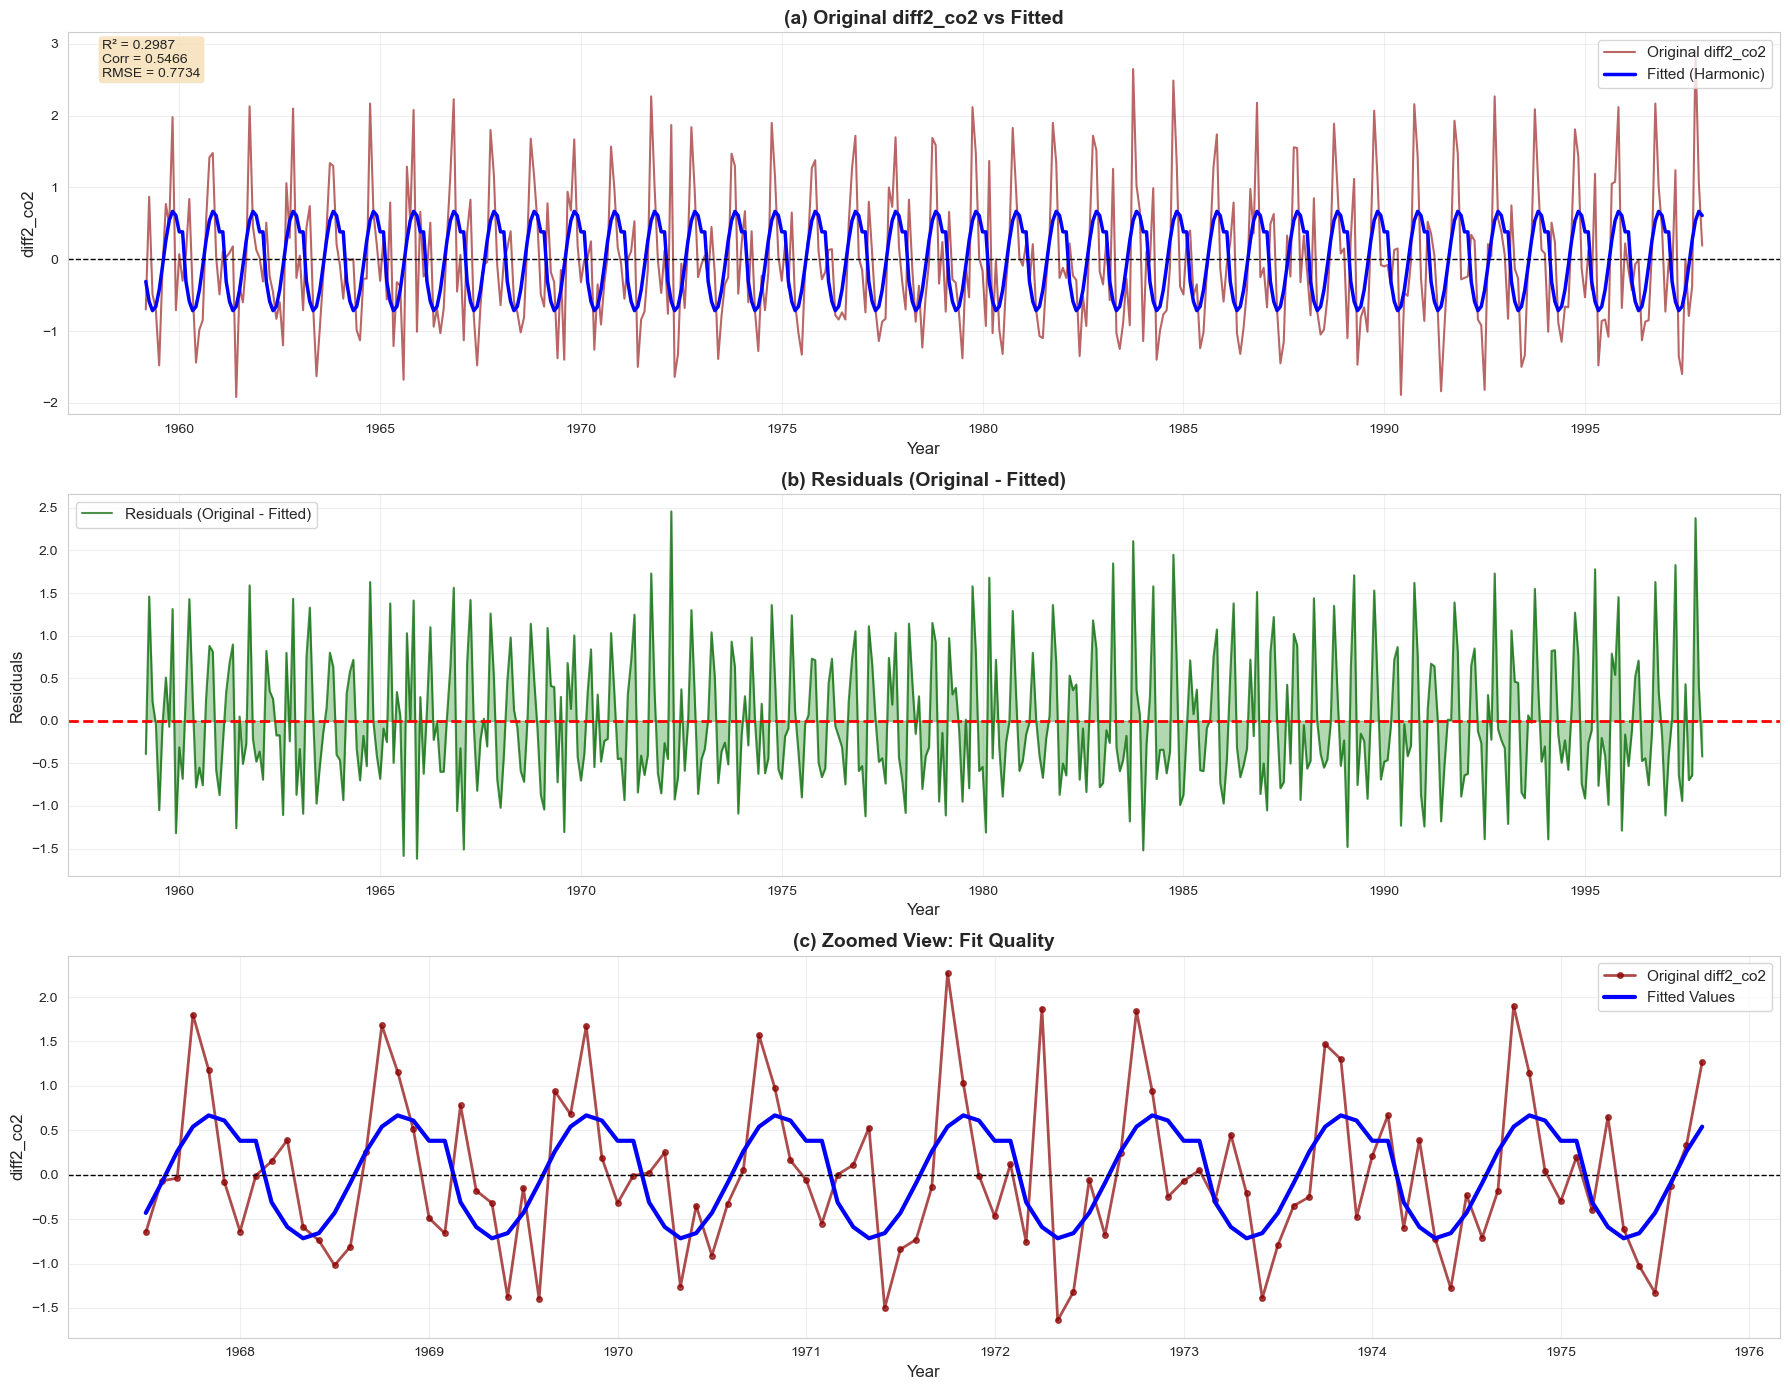

✓ Time-series comparison saved

[Step 4] Q–Q plots


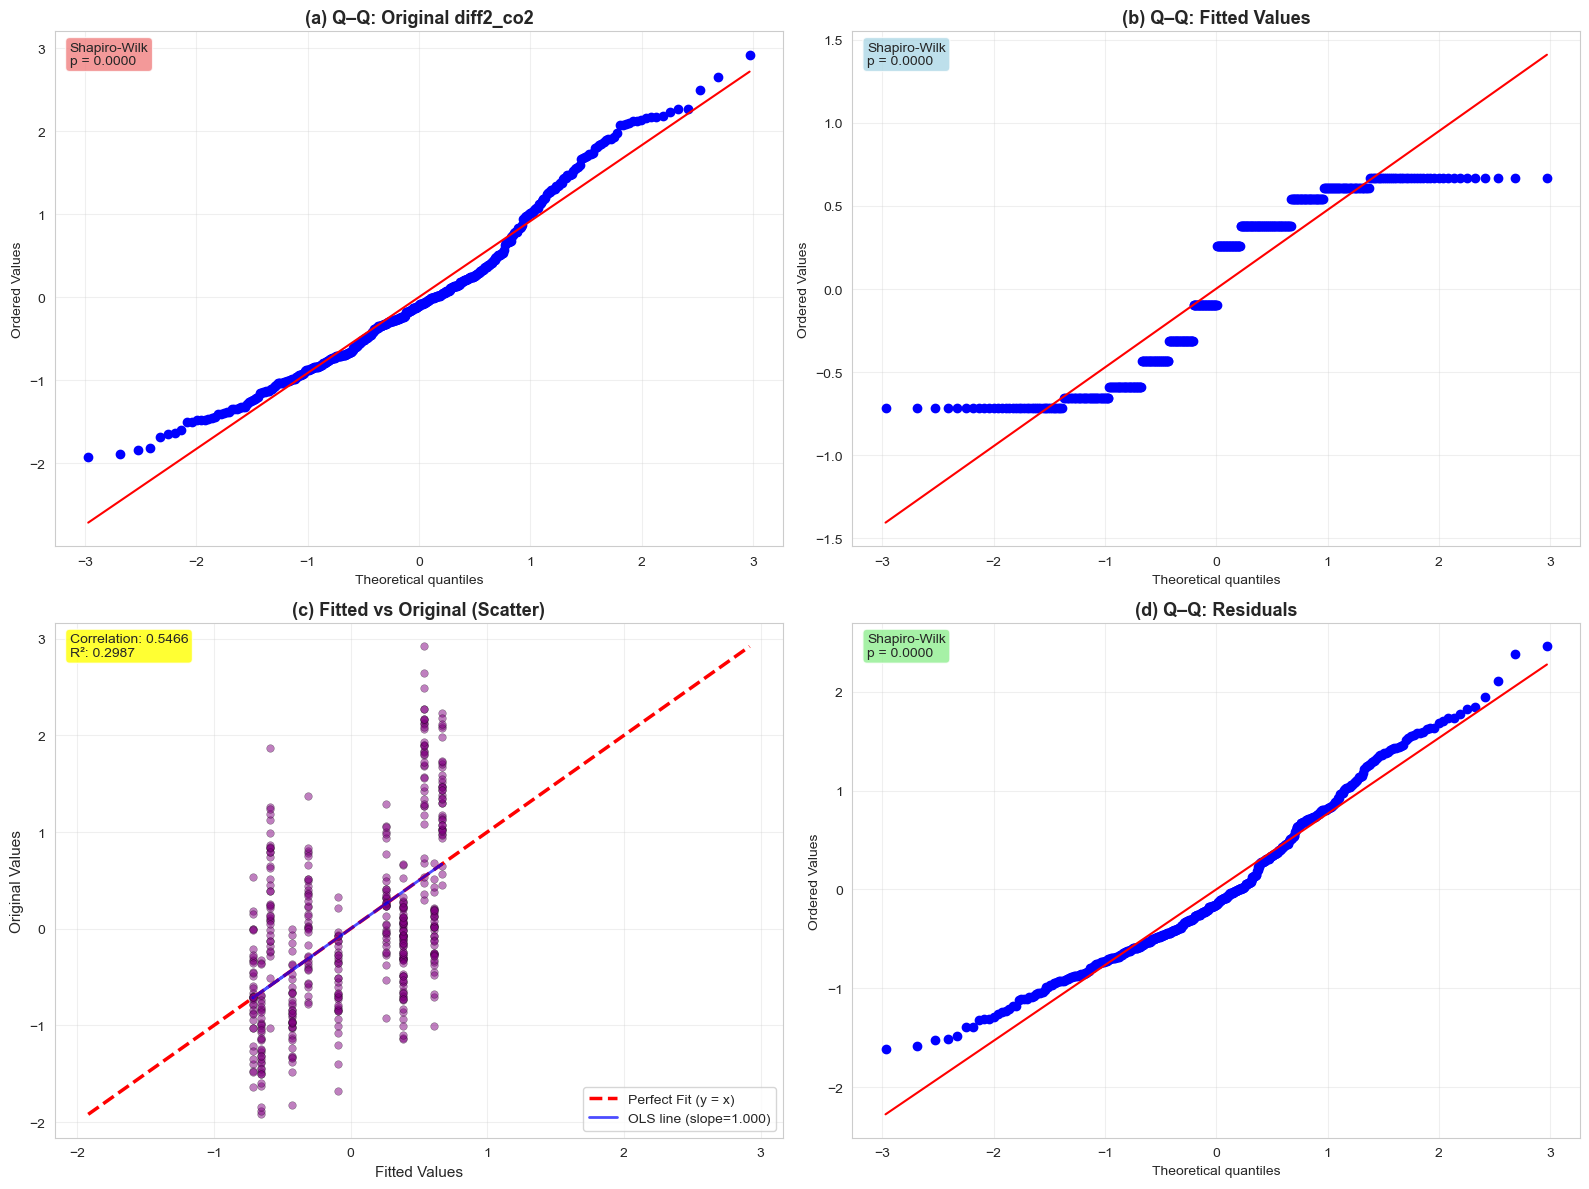

✓ Q–Q plots saved

[Step 5] Observations

Question: Compare fitted values to original diff2_co2 via a time-series plot and Q–Q plot.
What do you observe?

[Time-series observations]
1) Fit strength: R² = 0.2987; the harmonic fit explains ~29.9% of the
   variability in diff2_co2. The fitted line is smooth and clearly captures the annual cycle.
2) Seasonality: The 12-month periodicity is well captured by the cosine/sine terms. The original series
   fluctuates around the fitted curve with higher-frequency noise.
3) Residuals: Residuals fluctuate around zero (mean ≈ -1.43e-17), with dispersion summarized by
   RMSE = 0.7734 and MAE = 0.6296. No obvious large-scale pattern remains in the overlay.
4) Zoomed view: Peaks and troughs of the fitted series align well with the original, though fine-scale
   jagged movements remain in the original series (not captured by a single annual harmonic).

[Q–Q observations]
1) Original diff2_co2: Shapiro–Wilk p = 0.0000. Minor tail deviations are typica

In [9]:


# First and second differences
df['diff1_co2'] = df['co2'].diff(1)
df['diff2_co2'] = df['diff1_co2'].diff(1)

# Harmonic terms using calendar months
months = df.index.month
df['cos_annual'] = np.cos(2*np.pi*months/12)
df['sin_annual'] = np.sin(2*np.pi*months/12)

# Valid mask (second difference drops first 2 rows automatically)
valid_mask = df['diff2_co2'].notna()
df_valid = df[valid_mask].copy()

# OLS: diff2_co2 ~ const + cos + sin
X = df_valid[['cos_annual', 'sin_annual']].values
y = df_valid['diff2_co2'].values
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const)
results = model.fit()

df.loc[valid_mask, 'harmonic_fitted'] = results.fittedvalues
df.loc[valid_mask, 'harmonic_residuals'] = results.resid

print(f"✓ Harmonic regression done")
print(f"  R²: {results.rsquared:.4f}")
print(f"  Sample size: {len(df_valid)}")

# ========== Step 2: Summary stats ==========
print("\n" + "=" * 70)
print("[Step 2] Summary: original vs fitted")
print("=" * 70)

original = df_valid['diff2_co2']
fitted   = df.loc[valid_mask, 'harmonic_fitted']
residuals = df.loc[valid_mask, 'harmonic_residuals']

print("\n[Original diff2_co2]")
print(f"  Mean:   {original.mean():.8f}")
print(f"  Std:    {original.std():.4f}")
print(f"  Min:    {original.min():.4f}")
print(f"  Max:    {original.max():.4f}")
print(f"  Range:  {original.max() - original.min():.4f}")

print("\n[Fitted values]")
print(f"  Mean:   {fitted.mean():.8f}")
print(f"  Std:    {fitted.std():.4f}")
print(f"  Min:    {fitted.min():.4f}")
print(f"  Max:    {fitted.max():.4f}")
print(f"  Range:  {fitted.max() - fitted.min():.4f}")

print("\n[Fit quality]")
corr = np.corrcoef(original, fitted)[0, 1]
rmse = np.sqrt(np.mean(residuals**2))
mae  = np.mean(np.abs(residuals))
print(f"  R²:     {results.rsquared:.4f}")
print(f"  Corr:   {corr:.4f}")
print(f"  RMSE:   {rmse:.4f}")
print(f"  MAE:    {mae:.4f}")

# ========== Step 3: Time-series overlays ==========
print("\n" + "=" * 70)
print("[Step 3] Time-series comparison")
print("=" * 70)

fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# (a) Overlay original & fitted
axes[0].plot(original.index, original.values, lw=1.5,
             color='darkred', alpha=0.6, label='Original diff2_co2', zorder=1)
axes[0].plot(fitted.index, fitted.values, lw=2.5,
             color='blue', label='Fitted (Harmonic)', zorder=2)
axes[0].axhline(y=0, color='black', ls='--', lw=1)
axes[0].set_title('(a) Original diff2_co2 vs Fitted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('diff2_co2', fontsize=12)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3)

textstr = f'R² = {results.rsquared:.4f}\nCorr = {corr:.4f}\nRMSE = {rmse:.4f}'
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, fontsize=10,
             va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# (b) Residuals
axes[1].plot(residuals.index, residuals.values, lw=1.5,
             color='darkgreen', alpha=0.7, label='Residuals (Original - Fitted)')
axes[1].axhline(y=0, color='red', ls='--', lw=2)
axes[1].fill_between(residuals.index, 0, residuals.values, alpha=0.3, color='green')
axes[1].set_title('(b) Residuals (Original - Fitted)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# (c) Zoomed view
zoom_start, zoom_end = 100, 200
zoom_original = original.iloc[zoom_start:zoom_end]
zoom_fitted   = fitted.iloc[zoom_start:zoom_end]

axes[2].plot(zoom_original.index, zoom_original.values, lw=2,
             color='darkred', alpha=0.7, marker='o', markersize=4,
             label='Original diff2_co2')
axes[2].plot(zoom_fitted.index, zoom_fitted.values, lw=3,
             color='blue', label='Fitted Values')
axes[2].axhline(y=0, color='black', ls='--', lw=1)
axes[2].set_title('(c) Zoomed View: Fit Quality', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('diff2_co2', fontsize=12)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/lihong/Desktop/ats_proj_submit_code/result_plot/task6_fitted_vs_original_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Time-series comparison saved")

# ========== Step 4: Q–Q analyses ==========
print("\n" + "=" * 70)
print("[Step 4] Q–Q plots")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Q–Q: Original diff2_co2
stats.probplot(original, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('(a) Q–Q: Original diff2_co2', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
shapiro_orig, p_orig = stats.shapiro(original)
axes[0, 0].text(0.02, 0.98, f'Shapiro-Wilk\np = {p_orig:.4f}',
               transform=axes[0, 0].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# (b) Q–Q: Fitted values
stats.probplot(fitted, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('(b) Q–Q: Fitted Values', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
shapiro_fit, p_fit = stats.shapiro(fitted)
axes[0, 1].text(0.02, 0.98, f'Shapiro-Wilk\np = {p_fit:.4f}',
               transform=axes[0, 1].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# (c) Fitted vs Original (scatter; not a Q–Q)
axes[1, 0].scatter(fitted, original, alpha=0.5, s=30, color='purple',
                   edgecolors='black', linewidth=0.3)
mn, mx = min(fitted.min(), original.min()), max(fitted.max(), original.max())
axes[1, 0].plot([mn, mx], [mn, mx], 'r--', lw=2.5, label='Perfect Fit (y = x)')
z = np.polyfit(fitted, original, 1)
p_line = np.poly1d(z)
axes[1, 0].plot(fitted, p_line(fitted), 'b-', lw=2, alpha=0.7,
                label=f'OLS line (slope={z[0]:.3f})')
axes[1, 0].set_title('(c) Fitted vs Original (Scatter)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Fitted Values', fontsize=11)
axes[1, 0].set_ylabel('Original Values', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.02, 0.98, f'Correlation: {corr:.4f}\nR²: {results.rsquared:.4f}',
               transform=axes[1, 0].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# (d) Q–Q: Residuals
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('(d) Q–Q: Residuals', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
shapiro_res, p_res = stats.shapiro(residuals)
axes[1, 1].text(0.02, 0.98, f'Shapiro-Wilk\np = {p_res:.4f}',
               transform=axes[1, 1].transAxes, fontsize=10, va='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('/Users/lihong/Desktop/ats_proj_submit_code/result_plot/task6_qq_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Q–Q plots saved")

# ========== Step 5: Written observations (English) ==========
print("\n" + "=" * 70)
print("[Step 5] Observations")
print("=" * 70)

print(f"""
Question: Compare fitted values to original diff2_co2 via a time-series plot and Q–Q plot.
What do you observe?

[Time-series observations]
1) Fit strength: R² = {results.rsquared:.4f}; the harmonic fit explains ~{results.rsquared*100:.1f}% of the
   variability in diff2_co2. The fitted line is smooth and clearly captures the annual cycle.
2) Seasonality: The 12-month periodicity is well captured by the cosine/sine terms. The original series
   fluctuates around the fitted curve with higher-frequency noise.
3) Residuals: Residuals fluctuate around zero (mean ≈ {residuals.mean():.2e}), with dispersion summarized by
   RMSE = {rmse:.4f} and MAE = {mae:.4f}. No obvious large-scale pattern remains in the overlay.
4) Zoomed view: Peaks and troughs of the fitted series align well with the original, though fine-scale
   jagged movements remain in the original series (not captured by a single annual harmonic).

[Q–Q observations]
1) Original diff2_co2: Shapiro–Wilk p = {p_orig:.4f}. Minor tail deviations are typical; strict normality is
   not required for the seasonal fit but is informative.
2) Fitted values: Shapiro–Wilk p = {p_fit:.4f}. Since the model is sinusoidal, the fitted values are smoother
   and often appear closer to a symmetric distribution.
3) Fitted vs Original (scatter): Correlation = {corr:.4f}. Points cluster around the 45° line; the OLS line
   slope = {z[0]:.3f} indicates overall agreement but not a perfect one-to-one match.
4) Residuals Q–Q: Shapiro–Wilk p = {p_res:.4f}. Residual normality is acceptable if p > 0.05; otherwise, tails
   show mild deviations.

[Conclusion]
The harmonic regression captures the dominant 12-month seasonal structure in the second difference series.
Fit quality is solid (R² ≈ {results.rsquared:.2f}), residuals center around zero, and the time-series overlays
show good alignment of seasonal peaks and troughs. Remaining variance reflects higher-frequency noise or
additional seasonal components (e.g., semiannual); if needed, add higher harmonics to test for improvement.
""")

print("\n" + "=" * 70)
print("✓ Task 6.3 complete")
print("=" * 70)
print("\nSaved files:")
print("  - task6_fitted_vs_original_timeseries.png")
print("  - task6_qq_plots.png")
